# **Setup**

###First time executing

Set the ***first_time_executing*** variable to ***True*** if it's the first time executing the notebook

After executed, it will ask you to upload a file needed to download the dataset directly into Google Colab. To obtain that file:

*   Go to [Kaggle.com](https://www.kaggle.com/)
*   Go to your account
*   Under the voice API select "*Create new Token*"

This will download a *kaggle.json* file. Please upload that file in order to continue.

<br/>

**More info:**
The file contains your personal Kaggle API key: it will allow to download the dataset directly into Google Colab without downloading it in Google Drive beforehand (and without mounting the Drive).

The dataset will be unzipped directly in the current working directory (/content).

In [ ]:
first_time_executing = True

if first_time_executing:

  from google.colab import files
  import os

  !pip install -q kaggle

  # Please upload the kaggle.json file you downlad from going to kaggle.com > Your account > API > Create new Token
  files.upload()

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_full_name = "tawsifurrahman/covid19-radiography-database" # The dataset name must be: Username/Dataset_name
  !kaggle datasets download {dataset_full_name}

  dataset_name = os.path.basename(os.path.normpath(dataset_full_name))
  !unzip {dataset_name}.zip

### Imports and Parameters

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import random
import torch.nn as nn
import torch.nn.functional as F
import csv
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

dataset_path = 'COVID-19_Radiography_Dataset'
balanced_dataset_path = 'COVID-19_Radiography_Dataset_Balanced'
new_dataset_name = 'Covid_Dataset'
train_csv_path = 'train.csv'
test_csv_path = 'test.csv'
train_dir = os.path.join(new_dataset_name, 'train')
test_dir = os.path.join(new_dataset_name, 'test')

# classes = ['COVID', 'Normal', 'Viral Pneumonia']
classes = ['COVID', 'Normal']
NUM_CLASSES = 2

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.09
TEST_SIZE = 0.2
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

normalize = False

# If you want to train a convolutional set is_conv to True, if you want to train a fully connected, set is_conv to False
is_conv = True

torch.manual_seed(SEED)
random.seed(SEED)

#**Preprocessing**

### Data Balancing

#####Delete Lung Opacity Class

In [ ]:
shutil.copytree(dataset_path, balanced_dataset_path)

lung_opacity_dir = os.path.join(balanced_dataset_path, 'Lung_Opacity')

try:
  shutil.rmtree(lung_opacity_dir)
  print(f"Successfully deleted: {lung_opacity_dir}")
except OSError as e:
  print(f"Error: {lung_opacity_dir} - {e}")

Successfully deleted: COVID-19_Radiography_Dataset_Balanced/Lung_Opacity


#####Balance Normal and Covid class

In [ ]:
normal_images_path = os.path.join(balanced_dataset_path, 'Normal', 'images')
num_covid_images = len(os.listdir(os.path.join(balanced_dataset_path, 'COVID', 'images')))
normal_image_files = os.listdir(normal_images_path)

print(f'Before: {num_covid_images} Covid images / {len(normal_image_files)} Normal images')

images_to_delete = random.sample(normal_image_files, len(normal_image_files) - num_covid_images)
for image_file in images_to_delete:
  image_path = os.path.join(normal_images_path, image_file)
  os.remove(image_path)

print(f'After: {num_covid_images} Covid images / {len(os.listdir(normal_images_path))} Normal images')

Before: 3616 Covid images / 10192 Normal images
After: 3616 Covid images / 3616 Normal images


#####CSV creation, Create the new dataset folder, Convert all images to grayscale

In [ ]:
# Search for every image in the dataset, register the name and class within a CSV (train or test), convert the non-gray image into gray images (needed to calculate mean and std for Normalization) and move all the images into a new dataset folder partitioned train/test

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

class_encoding = {class_name: idx for idx, class_name in enumerate(classes)}

with open(train_csv_path, 'w', newline='') as train_csv_file, open(test_csv_path, 'w', newline='') as test_csv_file:
  train_csv_writer = csv.writer(train_csv_file)
  test_csv_writer = csv.writer(test_csv_file)

  # Header
  train_csv_writer.writerow(['Index_Name', 'Class'])
  test_csv_writer.writerow(['Index_Name', 'Class'])

  for class_name in classes:
    class_dir = os.path.join(balanced_dataset_path, class_name, 'images')
    images = os.listdir(class_dir)

    train_images, test_images = train_test_split(images, test_size=TEST_SIZE, random_state=SEED)

    for image in train_images:
      # Write into the CSV
      index_name = f"{image}"
      class_label = class_encoding[class_name]
      train_csv_writer.writerow([index_name, class_label])

      # Move files
      source_path = os.path.join(class_dir, image)
      pre_image = np.array(Image.open(source_path))

      # Check if they are not grey scale
      if len(pre_image.shape) > 2:
        grayscale_image = np.dot(pre_image[..., :3], [0.299, 0.587, 0.114])
        grayscale_image = Image.fromarray(grayscale_image.astype(np.uint8))
        os.remove(source_path)
        grayscale_image.save(source_path)
        print('Modified: ', source_path)

      if os.path.exists(source_path) == True:
        destination_path = os.path.join(train_dir, image)
        shutil.copy(source_path, destination_path)
      else:
        raise Exception('FILE NOT FOUND')

    for image in test_images:
      index_name = f"{image}"
      class_label = class_encoding[class_name]
      test_csv_writer.writerow([index_name, class_label])

      source_path = os.path.join(class_dir, image)
      pre_image = np.array(Image.open(source_path))

      if len(pre_image.shape) > 2:
        grayscale_image = np.dot(pre_image[..., :3], [0.299, 0.587, 0.114])
        grayscale_image = Image.fromarray(grayscale_image.astype(np.uint8))
        os.remove(source_path)
        grayscale_image.save(source_path)
        print('Modified: ', source_path)

      if os.path.exists(source_path) == True:
        destination_path = os.path.join(test_dir, image)
        shutil.copy(source_path, destination_path)
      else:
        raise Exception('FILE NOT FOUND')

Check if there is a non-grayscale image

In [ ]:
from PIL import Image
import os

def is_grayscale(image_path):
    # Open the image
    img = Image.open(image_path)

    # Check if it's a grayscale image
    return img.mode == 'L'

for root, dirs, files in os.walk(new_dataset_name):
    for file in files:

        if file.endswith('.jpg') or file.endswith('.png'):
            image_path = os.path.join(root, file)
            if not is_grayscale(image_path):
              raise Exception('Error: Multiple channels detected')
        else:
          raise Exception('Error: File format not supported')
print("All the images are grayscale")


All the images are grayscale


### Checkings

##### Plot class occurrencies

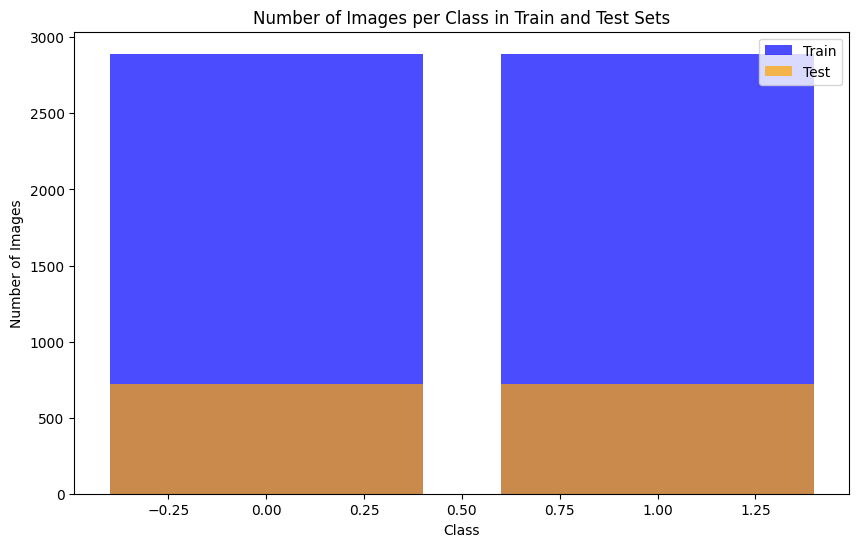

In [ ]:
import pandas as pd

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

train_counts = train_df['Class'].value_counts().sort_index()
test_counts = test_df['Class'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

plt.bar(train_counts.index, train_counts.values, color='blue', alpha=0.7, label='Train')
plt.bar(test_counts.index, test_counts.values, color='orange', alpha=0.7, label='Test')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Train and Test Sets')
plt.legend()
plt.show()

##### Check image dimensions

In [ ]:
# All images should be 299 x 299, This script doesn't check the channels

from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

# Loop through each image in the training folder
train_prev_dim = (0,0)
test_prev_dim = (0,0)
for img in os.listdir(train_dir):
  if img.endswith(".jpg") or img.endswith(".png"):
    img_path = os.path.join(train_dir, img)
    dimensions = get_image_dimensions(img_path)

    if train_prev_dim != dimensions:
      print("Train image dimensions: ", dimensions)
      train_prev_dim = dimensions

for img in os.listdir(test_dir):
  if img.endswith(".jpg") or img.endswith(".png"):
    img_path = os.path.join(test_dir, img)
    dimensions = get_image_dimensions(img_path)

    if test_prev_dim != dimensions:
      print("Test image dimensions: ", dimensions)
      test_prev_dim = dimensions

Train image dimensions:  (299, 299)
Test image dimensions:  (299, 299)


# **Prepare Dataset**

### Dataset creation

In [ ]:
# from torchvision.transforms import v2
import torchvision.transforms as v2
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader

resizedTransform = v2.Compose([
  # v2.RandomResizedCrop(size=(224, 224), antialias=True),
  # v2.RandomHorizontalFlip(p=0.5),
  # ToFloatTensor()
  v2.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
  # v2.ToDtype(torch.float32, scale=True)
  # v2.Normalize(mean=[0.485], std=[0.229]),
  if is_conv = False:
    v2.Resize(size=(150,150))
])

class CovidDataset(Dataset):
  def __init__(self, train_images_folder, test_images_folder, path_to_train_csv, path_to_test_csv, train=True, transform=None):
    super().__init__()
    self.train_data = pd.read_csv(path_to_train_csv)
    self.test_data = pd.read_csv(path_to_test_csv)
    self.train_images_folder = train_images_folder
    self.test_images_folder = test_images_folder
    self.images_files = os.listdir(train_images_folder)
    self.transform = transform
    self.train = train

  def __len__(self):
    return self.train_data.shape[0] if self.train else self.test_data.shape[0]

  def __getitem__(self, index):
    if self.train:
      image_file, label = self.train_data.iloc[index]
      image = np.array(Image.open(os.path.join(self.train_images_folder, image_file)))
    else:
      image_file, label = self.test_data.iloc[index]
      image = np.array(Image.open(os.path.join(self.test_images_folder, image_file)))

    if self.transform:
      # image = self.transform(image)["image"]
      image = self.transform(image)



    return image, label, image_file

###Dataset Normalization

In [ ]:
# if you think data can fit in your memory, change it_fits to True
if normalize:

# Compute mean and std of the data
  it_fits = False

  dataset = CovidDataset(
    train_images_folder = train_dir,
    test_images_folder = test_dir,
    path_to_train_csv = train_csv_path,
    path_to_test_csv = test_csv_path,
    transform = resizedTransform
  )

  if it_fits:
    loader = DataLoader(
      dataset=dataset, batch_size=len(pd.read_csv(train_csv_path)), num_workers=1, shuffle=True, pin_memory=True
    )
    data = next(iter(loader))
    mean = data[0].mean()
    std = data[0].std()
    print('Mean: ', mean, '\nStd: ', std)

  else:

    loader = DataLoader(
      dataset=dataset, batch_size=1000, num_workers=0, shuffle=True, pin_memory=True
    )
    num_of_pixels = len(pd.read_csv(train_csv_path)) *299*299
    total_sum = 0
    for batch in loader:
      total_sum += batch[0].sum()
      # since get item returned image, label, name_of_the_image, batch is composed of 3 elements: [0]: series of 1000 images, [1]: series of 1000 labels, [2]: series of 1000 image names
    mean = total_sum/num_of_pixels

    sum_of_squared_error = 0
    for batch in loader:
      sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
    std = torch.sqrt(sum_of_squared_error/num_of_pixels)

    print('Mean pre-normalization: ', mean)
    print('Standard Deviation pre-normalization: ', std)

  # Plot not normalized data

  num_bins = 50
  hist_sum = np.zeros(num_bins)
  # Define bin edges explicitly for the range [0, 1]
  bin_edges = np.linspace(-2, 2, num_bins + 1)
  for batch in loader:
      batch_data = batch[0].numpy()
      hist_batch, _ = np.histogram(batch_data, bins=bin_edges)
      hist_sum += hist_batch

  plt.bar(bin_edges[:-1], hist_sum, width=(bin_edges[1] - bin_edges[0]))
  plt.axvline(mean)
  plt.show()

  # Normalize the data

  resizedTransform = v2.Compose([
    v2.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    v2.Resize(size=(150,150)),
    v2.Normalize(mean=mean, std=std)
  ])

  normDataset = CovidDataset(
    train_images_folder = train_dir,
    test_images_folder = test_dir,
    path_to_train_csv = train_csv_path,
    path_to_test_csv = test_csv_path,
    transform = resizedTransform
  )

  normLoader = DataLoader(
    dataset=normDataset, batch_size=1000, num_workers=0, shuffle=True, pin_memory=True
  )

  num_of_pixels = len(pd.read_csv(train_csv_path)) *299*299
  total_sum = 0
  for batch in normLoader:
    total_sum += batch[0].sum()
    # since get item returned image, label, name_of_the_image, batch is composed of 3 elements: [0]: series of 1000 images, [1]: series of 1000 labels, [2]: series of 1000 image names
  mean = total_sum/num_of_pixels

  sum_of_squared_error = 0
  for batch in normLoader:
    sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
  std = torch.sqrt(sum_of_squared_error/num_of_pixels)

  print('Mean post-normalization: ', mean)
  print('Standard Deviation post-normalization: ', std)

  # Plot normalize data

  num_bins = 50
  hist_sum = np.zeros(num_bins)
  # Define bin edges explicitly for the range [0, 1]
  bin_edges = np.linspace(-2, 2, num_bins + 1)
  for batch in normLoader:
      batch_data = batch[0].numpy()
      hist_batch, _ = np.histogram(batch_data, bins=bin_edges)
      hist_sum += hist_batch

  plt.bar(bin_edges[:-1], hist_sum, width=(bin_edges[1] - bin_edges[0]))
  plt.axvline(mean)
  plt.show()

# **Create the Networks**

###Setup

#####Train and Test data loading

In [ ]:
train_dataset = CovidDataset(
  train_images_folder = train_dir,
  test_images_folder = test_dir,
  path_to_train_csv = train_csv_path,
  path_to_test_csv = test_csv_path,
  transform = resizedTransform
)

test_dataset = CovidDataset(
  train_images_folder = train_dir,
  test_images_folder = test_dir,
  path_to_train_csv = train_csv_path,
  path_to_test_csv = test_csv_path,
  train = False,
  transform = resizedTransform
)

train_loader = DataLoader(
  dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, pin_memory=True
)

test_loader = DataLoader(
  dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=True
)

#####Networks creation

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3)
    self.pool = nn.MaxPool2d(2, 2) # kernel size 2 and stride 2
    self.conv2 = nn.Conv2d(8, 16, 3)

    self.fc1 = nn.Linear(16*36*36, 5000)
    self.fc2 = nn.Linear(5000, NUM_CLASSES)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 16*36*36)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

 class FCNet(nn.Module):
   def __init__(self):
     super(FCNet, self).__init__()
     self.fc1 = nn.Linear(150*150, 5000)
     self.fc2 = nn.Linear(5000, 100)
     self.fc3 = nn.Linear(100, NUM_CLASSES)
     self.dropout1 = nn.Dropout2d(0.25)
     self.dropout2 = nn.Dropout2d(0.5)


   def forward(self, x):
     x = x.view(-1, 150*150)
     x = F.relu(self.fc1(x))
     x = self.dropout1(x)
     x = F.relu(self.fc2(x))
     x = self.dropout2(x)
     x = self.fc3(x)
     return x

###Train and Test

####Cross validation

To enable cross validation, we need to merge the train and test folder so that we can partition train and test set iteratively. The we will create another dataset from this folder and partition train and test set using the subset pytorch function

In [ ]:
import os
import shutil

train_dir = 'Covid_Dataset/train'
test_dir = 'Covid_Dataset/test'
full_dir = 'Covid_Dataset/full'

def copy_files(src_dir, dst_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Copy files from the source
    for filename in os.listdir(src_dir):
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)

        # Check if the file doesn't already exist
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"File {filename} already exists in the destination directory.")

# Copy files from train and test directories to the full directory
copy_files(train_dir, full_dir)
copy_files(test_dir, full_dir)

print("Files have been copied to the 'full' directory.")



In [ ]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class CombinedDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.gif']]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name)

        class_encoding = {class_name: idx for idx, class_name in enumerate(classes)}

        if self.transform:
            image = self.transform(image)

        label_str = img_name.split(os.sep)[-1].split('-')[0]
        # Convert class into label
        label = class_encoding[label_str]

        return image, label

FOLD 0
--------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.54it/s]

 10%|█         | 1/10 [00:36<05:29, 36.60s/it]


FC Precision:  0.7450199203187251
FC Recall:  0.5165745856353591
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:13<00:00, 12.95it/s]

 20%|██        | 2/10 [01:07<04:27, 33.47s/it]


FC Precision:  0.7637969094922737
FC Recall:  0.47790055248618785
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.74it/s]

 30%|███       | 3/10 [01:40<03:50, 32.93s/it]


FC Precision:  0.7293233082706767
FC Recall:  0.669889502762431
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.83it/s]

 40%|████      | 4/10 [02:11<03:14, 32.47s/it]


FC Precision:  0.8211764705882353
FC Recall:  0.48204419889502764
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.76it/s]

 50%|█████     | 5/10 [02:43<02:40, 32.19s/it]


FC Precision:  0.7597292724196277
FC Recall:  0.6201657458563536
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.74it/s]

 60%|██████    | 6/10 [03:16<02:09, 32.47s/it]


FC Precision:  0.9052369077306733
FC Recall:  0.5013812154696132
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.81it/s]

 70%|███████   | 7/10 [03:48<01:36, 32.11s/it]


FC Precision:  0.8549019607843137
FC Recall:  0.6022099447513812
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 1 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.41it/s]

 80%|████████  | 8/10 [04:20<01:04, 32.18s/it]


FC Precision:  0.5384615384615384
FC Recall:  0.9861878453038674
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.80it/s]

 90%|█████████ | 9/10 [04:51<00:31, 31.91s/it]


FC Precision:  0.6970033296337403
FC Recall:  0.8674033149171271
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.59it/s]

100%|██████████| 10/10 [05:23<00:00, 32.39s/it]



FC Precision:  0.6759834368530021
FC Recall:  0.9019337016574586
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 1 ... 0 1 1] 

[0.7346233586731168]


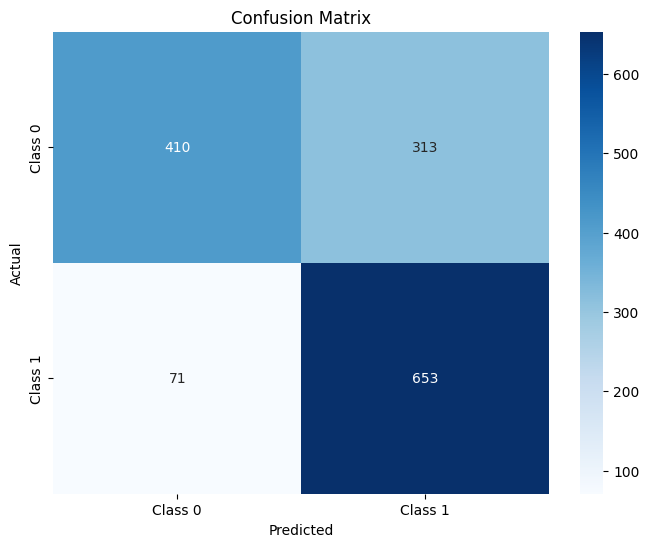

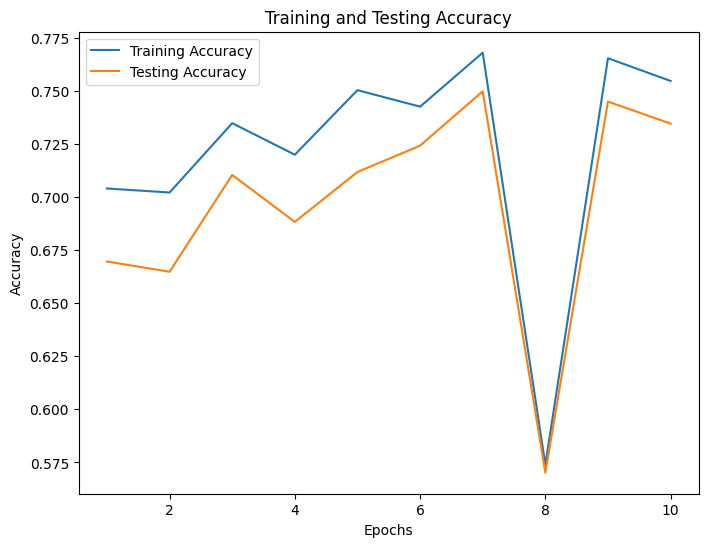

FOLD 1
--------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.39it/s]

 10%|█         | 1/10 [00:32<04:51, 32.34s/it]


FC Precision:  0.8554216867469879
FC Recall:  0.40746054519368724
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.43it/s]

 20%|██        | 2/10 [01:05<04:21, 32.74s/it]


FC Precision:  0.7474226804123711
FC Recall:  0.624103299856528
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.43it/s]

 30%|███       | 3/10 [01:37<03:48, 32.61s/it]


FC Precision:  0.5884995507637018
FC Recall:  0.93974175035868
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.52it/s]

 40%|████      | 4/10 [02:09<03:14, 32.41s/it]


FC Precision:  0.6912669126691267
FC Recall:  0.806312769010043
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.13it/s]

 50%|█████     | 5/10 [02:43<02:43, 32.75s/it]


FC Precision:  0.7551020408163265
FC Recall:  0.6901004304160688
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.42it/s]

 60%|██████    | 6/10 [03:15<02:10, 32.67s/it]


FC Precision:  0.7067183462532299
FC Recall:  0.7847919655667145
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.50it/s]

 70%|███████   | 7/10 [03:49<01:38, 32.86s/it]


FC Precision:  0.526029526029526
FC Recall:  0.9713055954088953
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.58it/s]

 80%|████████  | 8/10 [04:20<01:05, 32.54s/it]


FC Precision:  0.9259259259259259
FC Recall:  0.5380200860832137
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.33it/s]

 90%|█████████ | 9/10 [04:53<00:32, 32.43s/it]


FC Precision:  0.8543859649122807
FC Recall:  0.6987087517934003
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.62it/s]

100%|██████████| 10/10 [05:24<00:00, 32.49s/it]



FC Precision:  0.7967599410898379
FC Recall:  0.776183644189383
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 0 1 1] 

[0.7346233586731168, 0.796821008984105]


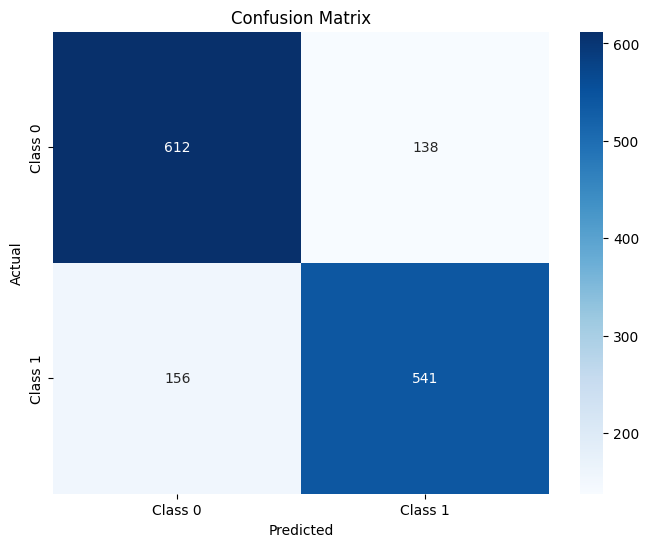

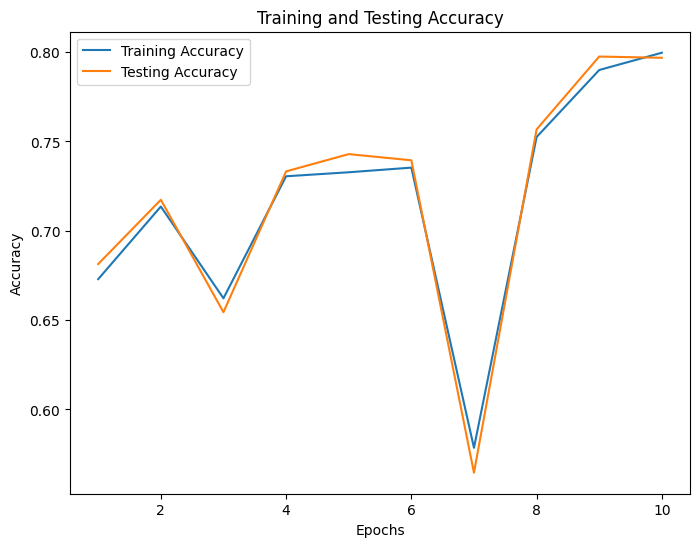

FOLD 2
--------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.45it/s]

 10%|█         | 1/10 [00:32<04:48, 32.11s/it]


FC Precision:  0.8691860465116279
FC Recall:  0.41412742382271467
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 12.04it/s]

 20%|██        | 2/10 [01:04<04:20, 32.56s/it]


FC Precision:  0.7308868501529052
FC Recall:  0.6620498614958449
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [1 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.38it/s]

 30%|███       | 3/10 [01:37<03:47, 32.54s/it]


FC Precision:  0.847255369928401
FC Recall:  0.4916897506925208
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.41it/s]

 40%|████      | 4/10 [02:10<03:16, 32.67s/it]


FC Precision:  0.6326923076923077
FC Recall:  0.9113573407202216
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.34it/s]

 50%|█████     | 5/10 [02:43<02:44, 32.90s/it]


FC Precision:  0.869281045751634
FC Recall:  0.5526315789473685
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.48it/s]

 60%|██████    | 6/10 [03:15<02:10, 32.70s/it]


FC Precision:  0.9807692307692307
FC Recall:  0.07063711911357341
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.09it/s]

 70%|███████   | 7/10 [03:48<01:38, 32.75s/it]


FC Precision:  0.9234567901234568
FC Recall:  0.518005540166205
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.19it/s]

 80%|████████  | 8/10 [04:22<01:05, 32.98s/it]


FC Precision:  0.8087986463620981
FC Recall:  0.6620498614958449
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.46it/s]

 90%|█████████ | 9/10 [04:54<00:32, 32.86s/it]


FC Precision:  0.6656346749226006
FC Recall:  0.8933518005540166
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.73it/s]

100%|██████████| 10/10 [05:28<00:00, 32.84s/it]



FC Precision:  0.8274021352313167
FC Recall:  0.6440443213296398
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [1 1 1 ... 0 1 0] 

[0.7346233586731168, 0.796821008984105, 0.7551867219917012]


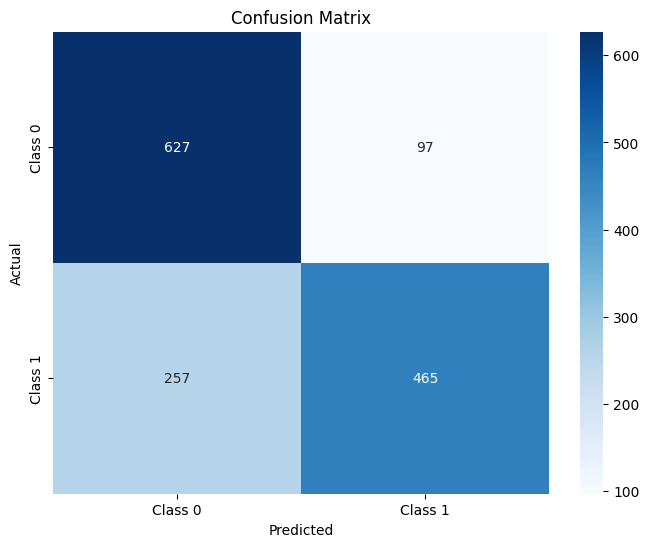

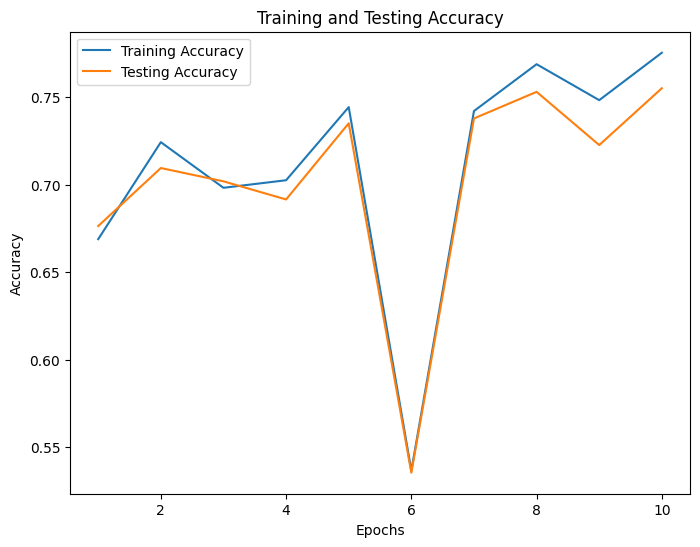

FOLD 3
--------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.20it/s]

 10%|█         | 1/10 [00:33<05:03, 33.73s/it]


FC Precision:  0.8680351906158358
FC Recall:  0.4038199181446112
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 0 ... 1 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.13it/s]

 20%|██        | 2/10 [01:06<04:25, 33.20s/it]


FC Precision:  0.5967184801381693
FC Recall:  0.9427012278308322
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.55it/s]

 30%|███       | 3/10 [01:40<03:55, 33.62s/it]


FC Precision:  0.7996422182468694
FC Recall:  0.6098226466575716
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 1 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.16it/s]

 40%|████      | 4/10 [02:14<03:21, 33.64s/it]


FC Precision:  0.8021201413427562
FC Recall:  0.6193724420190996
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 1 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.13it/s]

 50%|█████     | 5/10 [02:47<02:46, 33.39s/it]


FC Precision:  0.8181818181818182
FC Recall:  0.6384720327421555
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 1 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.72it/s]

 60%|██████    | 6/10 [03:21<02:14, 33.63s/it]


FC Precision:  1.0
FC Recall:  0.21964529331514324
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.98it/s]

 70%|███████   | 7/10 [03:55<01:41, 33.86s/it]


FC Precision:  0.9881656804733728
FC Recall:  0.22783083219645292
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.80it/s]

 80%|████████  | 8/10 [04:30<01:08, 34.05s/it]


FC Precision:  0.8777555110220441
FC Recall:  0.597544338335607
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.58it/s]

 90%|█████████ | 9/10 [05:04<00:34, 34.13s/it]


FC Precision:  0.7484957882069796
FC Recall:  0.8485675306957708
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 1 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.96it/s]

100%|██████████| 10/10 [05:38<00:00, 33.86s/it]



FC Precision:  0.89272030651341
FC Recall:  0.635743519781719
Labels:  [0 1 1 ... 1 0 1] 

Predicted:  [0 0 1 ... 0 1 0] 

[0.7346233586731168, 0.796821008984105, 0.7551867219917012, 0.7766251728907331]


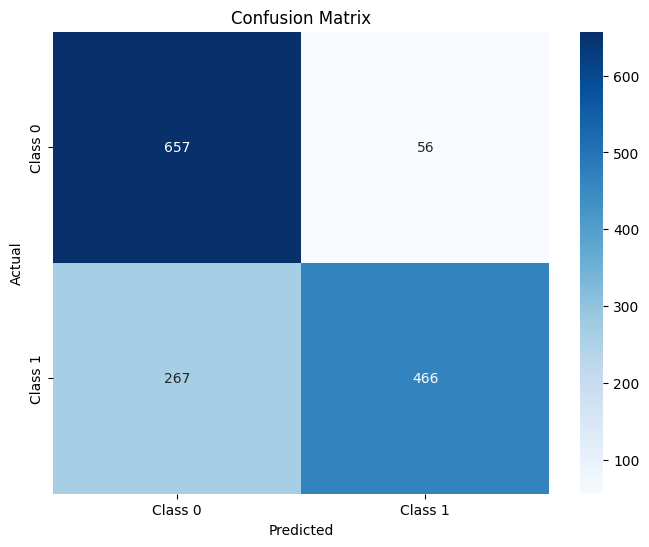

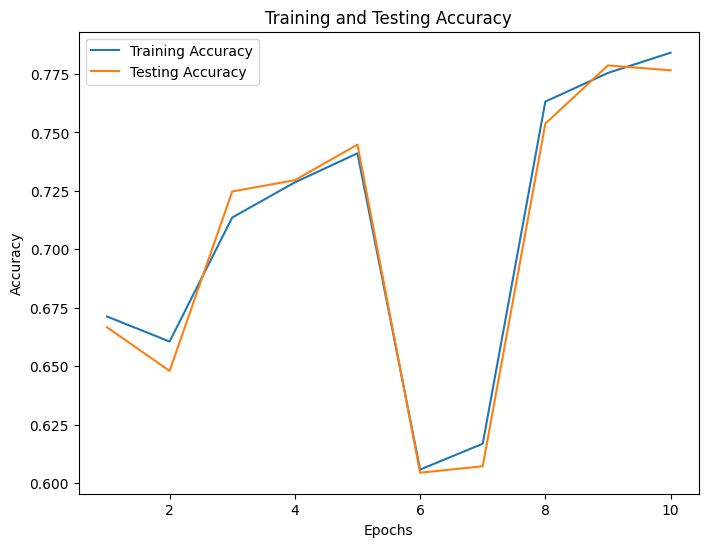

FOLD 4
--------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.89it/s]

 10%|█         | 1/10 [00:33<05:03, 33.71s/it]


FC Precision:  0.7139175257731959
FC Recall:  0.7486486486486487
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 0 ... 1 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.45it/s]

 20%|██        | 2/10 [01:09<04:38, 34.81s/it]


FC Precision:  0.5833333333333334
FC Recall:  0.9743243243243244
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 1 1 ... 1 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.66it/s]

 30%|███       | 3/10 [01:44<04:04, 34.97s/it]


FC Precision:  0.5153203342618384
FC Recall:  1.0
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.56it/s]

 40%|████      | 4/10 [02:19<03:29, 34.89s/it]


FC Precision:  0.9033149171270718
FC Recall:  0.4418918918918919
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 0 ... 1 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.85it/s]

 50%|█████     | 5/10 [02:54<02:54, 34.90s/it]


FC Precision:  0.6245583038869258
FC Recall:  0.9554054054054054
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 1 ... 1 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.39it/s]

 60%|██████    | 6/10 [03:29<02:20, 35.14s/it]


FC Precision:  0.6615532118887824
FC Recall:  0.9324324324324325
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 1 ... 1 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.73it/s]

 70%|███████   | 7/10 [04:04<01:44, 34.87s/it]


FC Precision:  0.8681318681318682
FC Recall:  0.6405405405405405
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 0 ... 1 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.46it/s]

 80%|████████  | 8/10 [04:39<01:10, 35.02s/it]


FC Precision:  0.7361894024802705
FC Recall:  0.8824324324324324
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 1 ... 1 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.60it/s]

 90%|█████████ | 9/10 [05:14<00:35, 35.08s/it]


FC Precision:  0.9300847457627118
FC Recall:  0.5932432432432433
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 0 ... 1 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.78it/s]

100%|██████████| 10/10 [05:49<00:00, 34.92s/it]



FC Precision:  0.8727569331158238
FC Recall:  0.722972972972973
Labels:  [1 0 0 ... 1 0 1] 

Predicted:  [1 0 0 ... 1 0 0] 

[0.7346233586731168, 0.796821008984105, 0.7551867219917012, 0.7766251728907331, 0.8042876901798064]


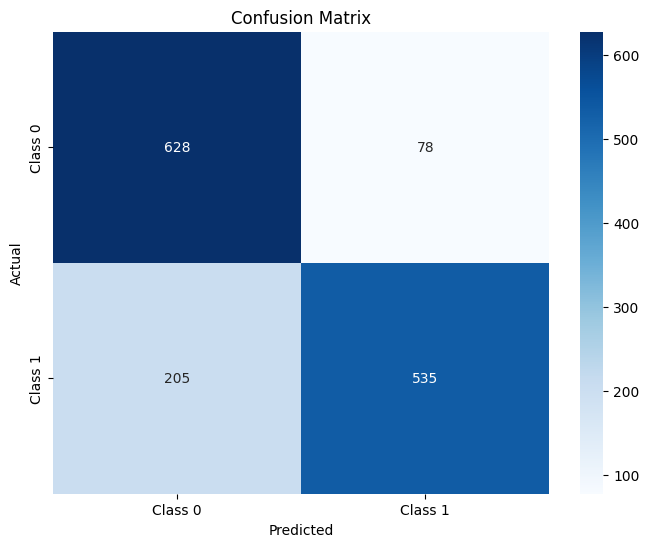

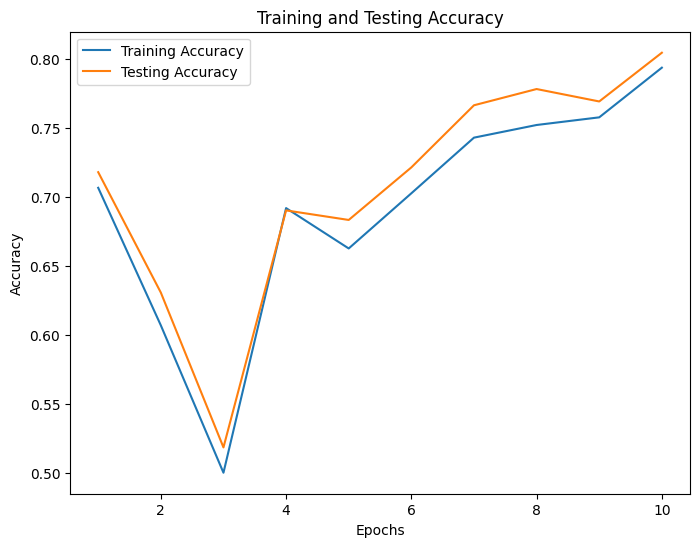

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np
import torch

full_dataset = CombinedDataset(folder='Covid_Dataset/full', transform=resizedTransform)

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# List of accuracies of each fold. Needed to calculate its average at the end
fold_accuracies = []

# K-Fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Create subsets
    train_subset = torch.utils.data.Subset(full_dataset, train_ids)
    val_subset = torch.utils.data.Subset(full_dataset, val_ids)

    # Define data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle = True
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle = False
    )

    # Set model to FCNet() or ConvNet()
    model = ConvNet() if is_conv else FCNet()

    model.to(DEVICE)

    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    num_batches_in_train_dataset = len(train_loader)

    training_accuracy_list = []
    testing_accuracy_list = []

    # For the confusion matrix i want the last epoch of testing performance
    last_epoch_predictions = []
    last_epoch_labels = []

    for epoch in range(NUM_EPOCHS):

      model.train()
      for i, data in tqdm(enumerate(train_loader)):
        images, labels = data

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        loss = loss_fun(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      print('TRAINING END')

      # Calculate accuracy of training and testing at the end of the training epoch

      num_correct_train = 0
      num_samples_train = 0

      model.eval()
      with torch.no_grad():
        for images, labels in train_loader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          outputs = model(images)

          _, predicted = torch.max(outputs, 1)

          num_samples_train += labels.size(0)
          num_correct_train += (predicted == labels).sum().item()

      training_accuracy = num_correct_train / num_samples_train
      training_accuracy_list.append(training_accuracy)

      num_correct_test = 0
      num_samples_test = 0
      all_predictions = []
      all_labels = []

      with torch.no_grad():
        for images, labels in val_loader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          outputs = model(images)

          _, predicted = torch.max(outputs, 1)

          all_predictions.append(predicted.cpu().data.numpy())
          all_labels.append(labels.cpu().data.numpy())

          num_samples_test += labels.size(0)
          num_correct_test += (predicted == labels).sum().item()

          # if it is the last epoch
          if epoch == NUM_EPOCHS-1:
            last_epoch_predictions.append(predicted.cpu().data.numpy())
            last_epoch_labels.append(labels.cpu().data.numpy())


      testing_accuracy = num_correct_test / num_samples_test
      testing_accuracy_list.append(testing_accuracy)

      # Calulculate Precision and Recall after flattening the predictions and labels
      flattened_array1 = np.concatenate(all_predictions).ravel()
      result_list1 = flattened_array1.tolist()
      prediction_list = np.array(result_list1)

      flattened_array2 = np.concatenate(all_labels).ravel()
      result_list2 = flattened_array2.tolist()
      labels_list = np.array(result_list2)

      precision, recall, _, __ = precision_recall_fscore_support(labels_list, prediction_list,average='binary')
      print('\nFC Precision: ', precision)
      print('FC Recall: ', recall)


    # Append this iteration's accuracy
    fold_accuracies.append(testing_accuracy)
    print(fold_accuracies)

    # Flat the labels and predictions of the last epoch
    flattened_last_epoch_predictions_array = np.concatenate(last_epoch_predictions).ravel()
    flattened_last_epoch_predictions_list = flattened_last_epoch_predictions_array.tolist()
    last_epoch_predictions_list = np.array(flattened_last_epoch_predictions_list)

    flattened_last_epoch_labels_array = np.concatenate(all_labels).ravel()
    flattened_last_epoch_labels_list = flattened_last_epoch_labels_array.tolist()
    last_epoch_labels_list = np.array(flattened_last_epoch_labels_list)

    # The confusion matrix has information of only the last epoch
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(last_epoch_labels_list, last_epoch_predictions_list)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # The accuracy charts take into account the accuracy on all the epochs
    epochs = range(1, NUM_EPOCHS + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, testing_accuracy_list, label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

print('FINAL ACCURACY: ', sum(fold_accuracies)/5)

